In [1]:
# Install and import libraries
!pip install pandas xlwings
import pandas as pd
import math
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize._numdiff import approx_derivative

In [3]:
# Data import
file_path = "/Users/elchulito/PlasticFADE_v2.xlsx"
sheet_name = "DS_Calibration"
data_degr = pd.read_excel(file_path, sheet_name=sheet_name, usecols="A,D:F,H", skiprows=1)
data_degr = data_degr[data_degr.iloc[:, 0].str.contains("D-PS-", na=False)]
print(data_degr)

# Known variables
k_degr_i_j = data_degr.iloc[:, 1].values
s = data_degr.iloc[:, 2].values
I_j = data_degr.iloc[:, 3].values
C_j = data_degr.iloc[:, 4].values
print(I_j)

     D.P.I.  k [i,j] [d-1]      s [cm-1]  I_j [W/m2]  C_j [CFU/ml]
25  D-PS-01       0.000085  29753.049688        2.22  0.000000e+00
26  D-PS-02       0.000233    103.624150       27.50  0.000000e+00
27  D-PS-03       0.000696    358.726190       27.50  0.000000e+00
28  D-PS-04       0.001084    670.666667        0.00  1.593000e+08
29  D-PS-05       0.001361     50.000000        0.00  9.805800e+08
30  D-PS-06       0.000742     50.000000        0.00  6.460500e+08
31  D-PS-07       0.002779     50.000000        0.00  1.734600e+09
32  D-PS-08       0.001707    300.000000        0.00  1.486800e+09
33  D-PS-09       0.000019     17.142857        1.65  2.500000e+04
[ 2.22 27.5  27.5   0.    0.    0.    0.    0.    1.65]


In [5]:
# Model definition (linear popt, log params_std)
def RC_degr(params, s, I_j, C_j):
    y_i, tau_i, xi_I_i, theta_i, xi_C_i, eta_i = params
    return y_i * (s**tau_i) * (I_j + xi_I_i)**theta_i * (C_j + xi_C_i)**eta_i

# Log-space curve fitting (more suitable for rate constants spanning orders of magnitude)
def log_model_degr(inputs, y_i, tau_i, xi_I_i, theta_i, xi_C_i, eta_i):
    s, I_j, C_j = inputs
    params = [y_i, tau_i, xi_I_i, theta_i, xi_C_i, eta_i]
    k_degr = RC_degr(params, s, I_j, C_j)
    return np.log(k_degr)
    
# Prepare inputs (X) and outputs (Y) arrays
X = (s, I_j, C_j)
Y = np.log(k_degr_i_j)

# Fitting settings (Initial guesses, bounds, convergence threshold, maximum iterations)
initial_guess = [1, 1, 1, 1, 1, 1]
bounds = ([0]*6, [np.inf]*6) # Lower and upper bounds
tolerance = 0.001  # 0.1%
max_iterations = 1000

lower_bounds = [0, 0, 0, 0, 0, 0]  # Lower bounds: Set manually
upper_bounds = [np.inf] * len(initial_guess)  # Upper bounds: Infinity

# The loop for iterations
for iteration in range(max_iterations):
    # Perform curve fitting (maxfev: maximum function evaluations, which is calculated as: maxfev=200×(number of parameters + 1)
    # Fit log-transformed model to log-transformed data
    popt, pcov = curve_fit(log_model_degr, X, Y, p0=initial_guess, bounds=bounds, maxfev=2000)
    # Calculate the relative difference
    relative_diff = np.abs(popt - initial_guess) / np.abs(initial_guess)
    # Update the initial guess
    initial_guess = popt
    # Check for convergence
    if np.all(relative_diff < tolerance):
        print(f"Converged after {iteration + 1} iterations.")
        break
else:
    print("Reached the maximum number of iterations without full convergence.")

# Fitted parameters (i.e., parameter estimates), in linear space
parameter_names = ['y_i', 'tau_i', 'xi_I_i', 'theta_i', 'xi_C_i', 'eta_i']
for name, value in zip(parameter_names, popt):
    print(f"{name}: {value}")

Converged after 29 iterations.
y_i: 2.6332623358380678e-09
tau_i: 0.5544969343235189
xi_I_i: 2.780404080388756
theta_i: 2.560997954120205
xi_C_i: 2.085398326541
eta_i: 0.385415066505598


In [7]:
# Save fitted parameters back to Excel (without modifying)
import xlwings as xw

# File path and sheet details
file_path = "/Users/elchulito/PlasticFADE_v2.xlsx"
sheet_name = "Drop-down lists"
start_row = 21  # Change for other polymer types (17-26)
start_col = "C"

# Fitted parameters
fitted_parameters = popt

# Start the Excel application and open the workbook
app = xw.App(visible=True)  # Set visible=True to open the file automatically
workbook = app.books.open(file_path)
sheet = workbook.sheets[sheet_name]

# Write the fitted parameters to the specified cells
for i, value in enumerate(fitted_parameters):
    column = chr(ord(start_col) + i)
    cell = f"{column}{start_row}"
    sheet.range(cell).value = value

# Save the workbook
workbook.save()
workbook.close()
app.quit()

In [9]:
# Compute determination coefficient (R^2) while fully staying in log-space
# Step 1: Compute log-observed and log-predicted
eps = 1e-10  # Small constant to avoid log(0) issues
log_obs = np.log(k_degr_i_j + eps)  # Avoid log(0)
log_pred = log_model_degr(X, *popt)  # Already log(k_pred)


# Step 2: Compute SS_res and SS_tot in log-space
ss_res_log = np.sum((log_obs - log_pred)**2)
ss_tot_log = np.sum((log_obs - np.mean(log_obs))**2)

# Step 3: Compute R² in log-space
r_squared_log = 1 - (ss_res_log / ss_tot_log)
print(f"Log-space R² (pseudo-R²): {r_squared_log:.3f}")

Log-space R² (pseudo-R²): 0.909


In [13]:
# Compute the Fisher Information Matrix
from scipy.optimize._numdiff import approx_derivative

# --- Step 1: Define the wrapped model for Jacobian estimation ---
def wrapped_model(params):
    return np.log(model_degr(inputs, *params))  # Assuming log-normally distributed residuals

# --- Step 2: Compute residuals and estimated variance ---
residuals = np.log(k_degr_i_j) - wrapped_model(popt)  # log of observed data - log of model output
sigma2 = np.var(residuals, ddof=1)

# --- Step 3: Compute the Jacobian at fitted parameters ---
# J = approx_derivative(wrapped_model, popt, method='2-point/3-point')
J = approx_derivative(wrapped_model, popt, method='cs')

# --- Step 4: Compute Fisher Information Matrix (round to 3 significant digits) ---
FIM = (1 / sigma2) * J.T @ J

# --- Step 5: Compute standard deviations from the inverse of FIM ---
# cov_est = np.linalg.inv(FIM)
cov_est = np.linalg.pinv(FIM) # Uses the Moore–Penrose pseudo-inverse, which handles rank-deficient matrices gracefully
param_std = np.sqrt(np.diag(cov_est))

# --- Step 6: Compute relative uncertainty
param_names = ['x_i', 'tau_i', 'y_i', 'theta_i', 'z_i', 'eta_i']
relative_uncertainty = 100 * param_std / np.abs(popt)

# --- Format all values as strings with 3 significant digits ---
summary_df = pd.DataFrame({
    'Parameter': param_names,
    'Estimate': popt,
    'Std. Dev (σ)': param_std,
    'Relative Uncertainty (%)': relative_uncertainty
})

# --- Output ---
pd.set_option('display.float_format', '{:.2e}'.format)
print("Inverse of Fisher Information Matrix (parameter covariance matrix):")
print(np.array2string(cov_est, formatter={'float_kind': lambda x: f"{x:.2e}"}))
print("\nStandard deviations of parameter estimates (Cramér–Rao bounds): See the table below")
print("📋 Relative Uncertainty Table:")
print(summary_df.to_string(index=False))
print("\nNumber of residuals:", len(residuals))

Inverse of Fisher Information Matrix (parameter covariance matrix):
[[4.45e-06 -1.77e-04 5.54e-06 -2.36e-04 -4.64e-11 1.96e-05]
 [-1.77e-04 1.06e-02 -2.11e-04 3.52e-03 -1.60e-08 5.94e-03]
 [5.54e-06 -2.11e-04 8.13e-06 -4.78e-04 3.84e-10 -1.66e-04]
 [-2.36e-04 3.52e-03 -4.78e-04 5.26e-02 9.43e-09 -2.57e-03]
 [-4.64e-11 -1.60e-08 3.84e-10 9.43e-09 5.80e-13 -2.42e-07]
 [1.96e-05 5.94e-03 -1.66e-04 -2.57e-03 -2.42e-07 1.01e-01]]

Standard deviations of parameter estimates (Cramér–Rao bounds): See the table below
📋 Relative Uncertainty Table:
Parameter  Estimate  Std. Dev (σ)  Relative Uncertainty (%)
      x_i  5.27e-03      2.11e-03                  4.00e+01
    tau_i  1.00e-10      1.03e-01                  1.03e+11
      y_i  5.86e-03      2.85e-03                  4.86e+01
  theta_i  8.18e-01      2.29e-01                  2.81e+01
      z_i  1.19e-07      7.62e-07                  6.40e+02
    eta_i  7.38e-01      3.18e-01                  4.31e+01

Number of residuals: 9


In [15]:
# Save standard deviations and relative uncertainty of fitted parameters back to Excel (without modifying)
import xlwings as xw

cols_to_write = ['Estimate', 'Std. Dev (σ)', 'Relative Uncertainty (%)']
data_to_write = summary_df[cols_to_write].values.tolist()

wb = xw.Book('/Users/elchulito/Library/CloudStorage/OneDrive-polymtlus/0 - A_Database and methodology_PhD/PlasticFADE.xlsx')  # Use full path if not in working directory
ws = wb.sheets['Uncertainty']

start_cell = 'C57'  # Change this index for other polymers
ws.range(start_cell).value = data_to_write

wb.save()
wb.close()

In [11]:
# Import the original data points and calculated RCs from PlasticFADE
import matplotlib.pyplot as plt
file_path = "/Users/elchulito/PlasticFADE_v2.xlsx"
data_comp = pd.read_excel(file_path, sheet_name="Scatterplot", usecols="I:L", skiprows=5)  # Change usecols and skiprows for other polymers
data_comp = data_comp[data_comp.iloc[:, 0].str.contains("D-PS-", na=False)] # Change for other polymer types
pd.set_option('display.float_format', '{:.2e}'.format)
print(data_comp)

   D.P.I..1 R.E.S..1 k_model [d-1].1 k [i,j] [d-1].1
6   D-PS-01       UV        6.52e-05        8.47e-05
7   D-PS-02       UV        2.85e-04        2.33e-04
8   D-PS-03       UV        5.67e-04        6.96e-04
9   D-PS-04       MC        1.93e-03        1.08e-03
10  D-PS-05       MC        9.23e-04        1.36e-03
11  D-PS-06       MC        7.86e-04        7.42e-04
12  D-PS-07       MC        1.15e-03        2.78e-03
13  D-PS-08       MC        2.93e-03        1.71e-03
14  D-PS-09    UV+MC        2.85e-05        1.87e-05


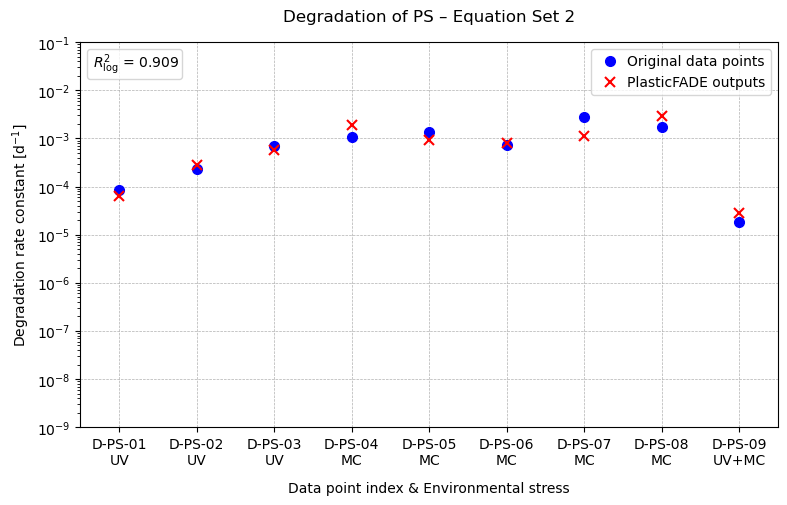

In [13]:
# Plot the modeling results with the original data points in the same graph
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(9, 5))
df = pd.DataFrame(data_comp)
df['x_labels'] = df['D.P.I..1'] + '\n' + df['R.E.S..1']

# Plot original data and model output
plt.plot(df['D.P.I..1'], df['k [i,j] [d-1].1'], 'bo', markersize=7, label='Original data points')  # check why there's a ".1"
plt.plot(df['D.P.I..1'], df['k_model [d-1].1'], 'rx', markersize=7, markeredgewidth=1.5, label='PlasticFADE outputs')  # check why there's a ".1"

# Main legend
main_legend = ax.legend(loc='upper right', handletextpad=0.2)
ax.add_artist(main_legend)  # keep it when adding another legend

# --- Create second legend entry for R² without marker ---
r2_label = f'$R_{{\\mathrm{{log}}}}^2$ = {r_squared_log:.3f}'

# Make an invisible Line2D object (no line, no marker)
empty_line = Line2D([], [], color='none')

# Add the second legend with zero padding before the text
r2_legend = ax.legend([empty_line], [r2_label], loc='upper left', frameon=True, handlelength=0, handletextpad=0.2, borderpad=0.2)

plt.xticks(df['D.P.I..1'], df['x_labels'])
plt.xlim(-0.5, len(data_comp) - 0.5)
ax.set_xlabel('Data point index & Environmental stress', labelpad=10)
ax.set_ylabel('Degradation rate constant [d$^{-1}$]')
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-1)
ax.grid(True, which="major", ls="--", lw=0.5)
ax.set_title('Degradation of PS – Equation Set 2', pad=15)

plt.savefig("/Users/elchulito/D_PS_S2.png", dpi=600, bbox_inches='tight')
plt.show()